In [2]:
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.14"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.14) to /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-install-o4nuho11/tsfm-public_c758deef9bd74757bc93f69b16185997
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-install-o4nuho11/tsfm-public_c758deef9bd74757bc93f69b16185997
  Running command git checkout -q fea9e7e578065d38491f777422a43cea71564994
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit fea9e7e578065d38491f777422a43cea71564994
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### As described on hugging-face: "The current open-source version supports point forecasting use-cases specifically ranging from minutely to hourly resolutions (Ex. 10 min, 15 min, 1 hour.)". it is probably not suitable to forecast the frequencies of our dataset. Hence only perform some test on daily frequency.

HF: https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2 

Demo: https://github.com/ibm-granite/granite-tsfm/blob/main/notebooks/hfdemo/ttm_getting_started.ipynb

### The current open-source model also is pre-configurated to a fixed context window of 512

# context: 512, prediction: 12

INFO:p-95468:t-8002182208:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-95468:t-8002182208:get_model.py:get_model:Selected prediction_length = 96
                    Hence, TTM will forecast using the `prediction_filter_length` argument to provide the requested prediction length.
                    Supported context lengths (CL) and forecast/prediction lengths (FL) for Model Card: ibm-granite/granite-timeseries-ttm-r2 are
                    {'CL': [512, 1024, 1536], 'FL': [96, 192, 336, 720]}
/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO:p-95468:t-8002182208:get_model.py:get_model:Model loaded successfully!
INFO:p-95468:t-8002182208:get_model.py:get_model:[TTM] context_len = 512, forecast_len = 96



Full Period Metrics:
MAE: 107.5520
MSE: 13696.0050
RMSE: 117.0299
MAPE: 1.7775
SMAPE: 1.7956
MASE: 3.5997


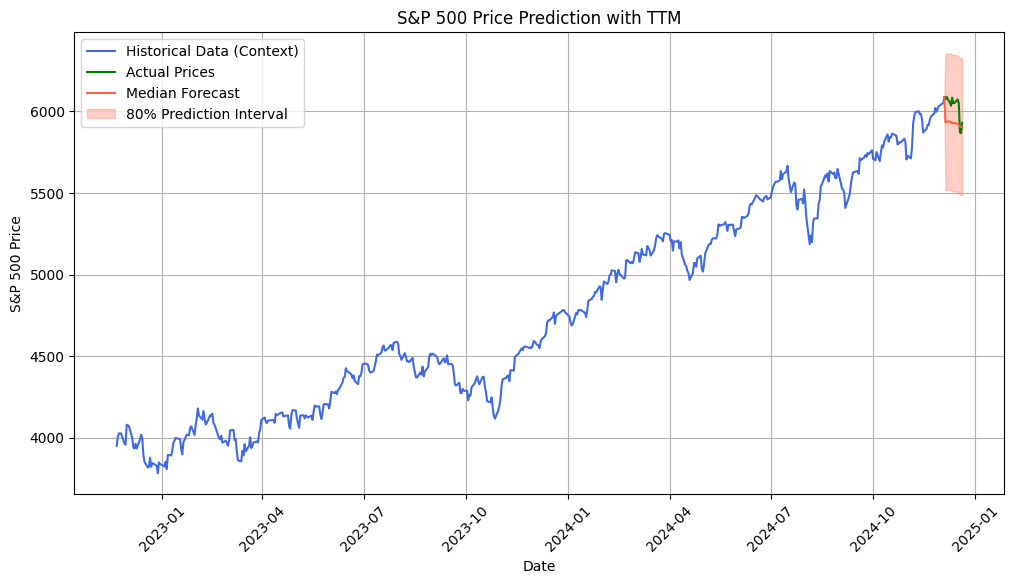


COVID Period Metrics:
MAE: 4429.6994
MSE: 19698865.8776
RMSE: 4438.3404
MAPE: 93.9716
SMAPE: 178.1520
MASE: 130.5226


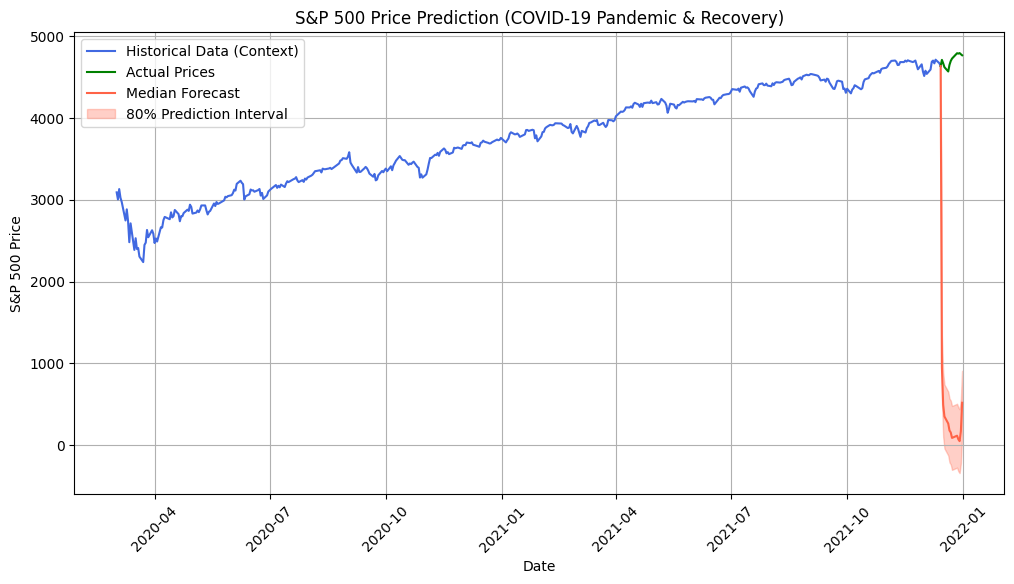

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tsfm_public.toolkit.get_model import get_model

from data.snp500 import snp500_daily
from utils.metrics import calculate_metrics
from utils.visualization import plot_forecast

CONTEXT_WINDOW = 512
PREDICTION_WINDOW = 12

# Initialize TTM model
model = get_model(
    model_path="ibm-granite/granite-timeseries-ttm-r2",
    context_length=CONTEXT_WINDOW,
    prediction_length=PREDICTION_WINDOW
)

# Prepare the data - using raw Close prices
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]


def generate_forecast(context_data):
    """Generate and process forecast using TTM"""
    context = np.asarray(context_data).flatten()

    # If there's more context than needed, slice to the last CONTEXT_WINDOW elements.
    if len(context) > CONTEXT_WINDOW:
        context = context[-CONTEXT_WINDOW:]

    # If there's less context than needed, pad to the left.
    if len(context) < CONTEXT_WINDOW:
        padding = CONTEXT_WINDOW - len(context)
        context = np.pad(context, (padding, 0), mode='constant', constant_values=0)

    mean = np.mean(context)
    std = np.std(context)
    context_normalized = (context - mean) / std

    # (batch=1, sequence_length=512, channels=1)
    context_tensor = torch.tensor(context_normalized).float().unsqueeze(0).unsqueeze(-1)
    # If your TTM model expects 7 channels, replicate across that dimension
    context_tensor = context_tensor.repeat(1, 1, 7)

    with torch.no_grad():
        outputs = model(past_values=context_tensor)

    # outputs.prediction_outputs: shape => (batch_size=1, prediction_length, channels=7)
    predictions = outputs.prediction_outputs.squeeze().numpy()[:, 0]
    predictions = predictions * std + mean

    forecast_std = np.std(context) * 0.5
    median = predictions
    low = median - 1.28 * forecast_std
    high = median + 1.28 * forecast_std

    return low, median, high

# Generate full period forecast
context = sp500_d["Close"].values[-CONTEXT_WINDOW:]
if len(context) < CONTEXT_WINDOW:
    context = np.pad(context, (CONTEXT_WINDOW - len(context), 0), mode='constant', constant_values=0)

low, median, high = generate_forecast(context)

# Calculate and print metrics for full period
actual_prices = sp500_d["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_d["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_d,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with TTM",
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_d[
    (sp500_d["Date"] >= covid_start_date) & (sp500_d["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)
if len(covid_context) < CONTEXT_WINDOW:
    covid_context = np.pad(covid_context, (CONTEXT_WINDOW - len(covid_context), 0), mode='constant', constant_values=0)

low_covid, median_covid, high_covid = generate_forecast(covid_context)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)


# context: 512, prediction: 24

INFO:p-95468:t-8002182208:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-95468:t-8002182208:get_model.py:get_model:Selected prediction_length = 96
                    Hence, TTM will forecast using the `prediction_filter_length` argument to provide the requested prediction length.
                    Supported context lengths (CL) and forecast/prediction lengths (FL) for Model Card: ibm-granite/granite-timeseries-ttm-r2 are
                    {'CL': [512, 1024, 1536], 'FL': [96, 192, 336, 720]}
/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO:p-95468:t-8002182208:get_model.py:get_model:Model loaded successfully!
INFO:p-95468:t-8002182208:get_model.py:get_model:[TTM] context_len = 512, forecast_len = 96



Full Period Metrics:
MAE: 103.9885
MSE: 15027.3816
RMSE: 122.5862
MAPE: 1.7199
SMAPE: 1.7404
MASE: 3.4090


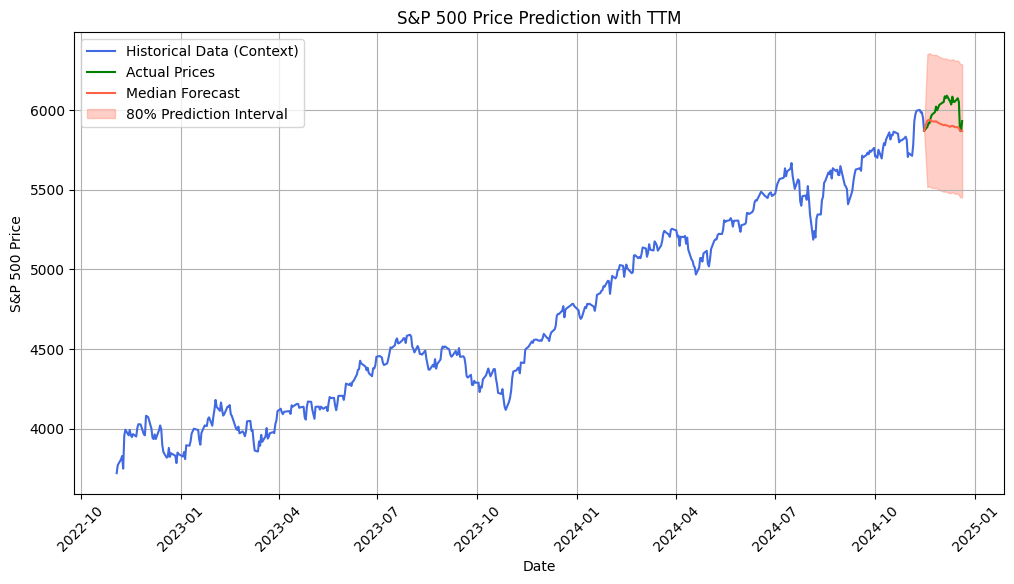


COVID Period Metrics:
MAE: 4517.4454
MSE: 20487653.8903
RMSE: 4526.3290
MAPE: 96.7457
SMAPE: 188.4205
MASE: 135.0745


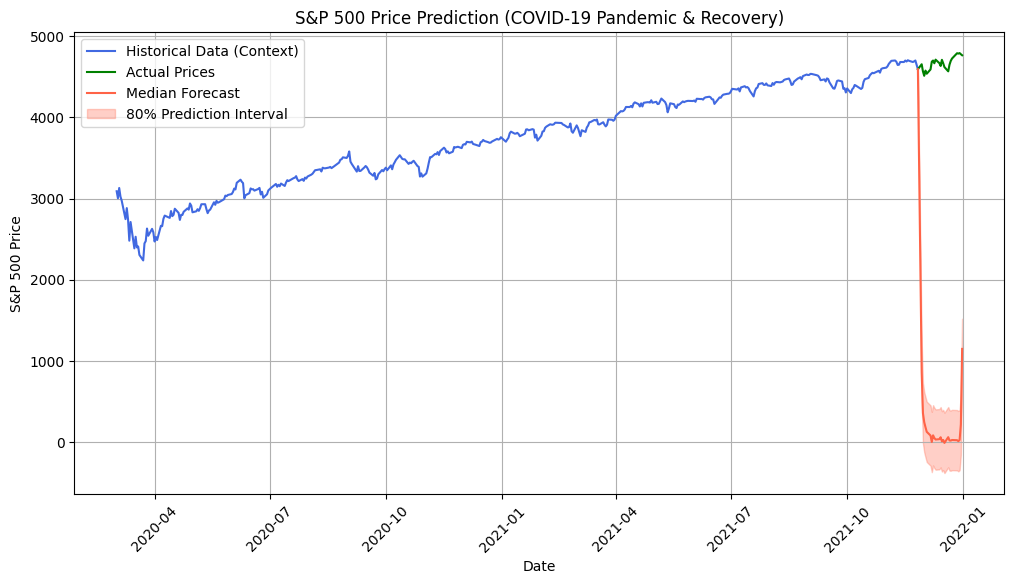

In [27]:
import numpy as np
import torch
from tsfm_public.toolkit.get_model import get_model

from data.snp500 import snp500_daily
from utils.metrics import calculate_metrics
from utils.visualization import plot_forecast

CONTEXT_WINDOW = 512
PREDICTION_WINDOW = 24

# Initialize TTM model
model = get_model(
    model_path="ibm-granite/granite-timeseries-ttm-r2",
    context_length=CONTEXT_WINDOW,
    prediction_length=PREDICTION_WINDOW
)

# Prepare the data - using raw Close prices
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]


def generate_forecast(context_data):
    """Generate and process forecast using TTM"""
    context = np.asarray(context_data).flatten()

    # If there's more context than needed, slice to the last CONTEXT_WINDOW elements.
    if len(context) > CONTEXT_WINDOW:
        context = context[-CONTEXT_WINDOW:]

    # If there's less context than needed, pad to the left.
    if len(context) < CONTEXT_WINDOW:
        padding = CONTEXT_WINDOW - len(context)
        context = np.pad(context, (padding, 0), mode='constant', constant_values=0)

    mean = np.mean(context)
    std = np.std(context)
    context_normalized = (context - mean) / std

    # (batch=1, sequence_length=512, channels=1)
    context_tensor = torch.tensor(context_normalized).float().unsqueeze(0).unsqueeze(-1)
    # If your TTM model expects 7 channels, replicate across that dimension
    context_tensor = context_tensor.repeat(1, 1, 7)

    with torch.no_grad():
        outputs = model(past_values=context_tensor)

    # outputs.prediction_outputs: shape => (batch_size=1, prediction_length, channels=7)
    predictions = outputs.prediction_outputs.squeeze().numpy()[:, 0]
    predictions = predictions * std + mean

    forecast_std = np.std(context) * 0.5
    median = predictions
    low = median - 1.28 * forecast_std
    high = median + 1.28 * forecast_std

    return low, median, high

# Generate full period forecast
context = sp500_d["Close"].values[-CONTEXT_WINDOW:]
if len(context) < CONTEXT_WINDOW:
    context = np.pad(context, (CONTEXT_WINDOW - len(context), 0), mode='constant', constant_values=0)

low, median, high = generate_forecast(context)

# Calculate and print metrics for full period
actual_prices = sp500_d["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_d["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_d,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with TTM",
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_d[
    (sp500_d["Date"] >= covid_start_date) & (sp500_d["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)
if len(covid_context) < CONTEXT_WINDOW:
    covid_context = np.pad(covid_context, (CONTEXT_WINDOW - len(covid_context), 0), mode='constant', constant_values=0)

low_covid, median_covid, high_covid = generate_forecast(covid_context)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)

# context: 512, prediction: 48

INFO:p-95468:t-8002182208:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-95468:t-8002182208:get_model.py:get_model:Selected prediction_length = 96
                    Hence, TTM will forecast using the `prediction_filter_length` argument to provide the requested prediction length.
                    Supported context lengths (CL) and forecast/prediction lengths (FL) for Model Card: ibm-granite/granite-timeseries-ttm-r2 are
                    {'CL': [512, 1024, 1536], 'FL': [96, 192, 336, 720]}
/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO:p-95468:t-8002182208:get_model.py:get_model:Model loaded successfully!
INFO:p-95468:t-8002182208:get_model.py:get_model:[TTM] context_len = 512, forecast_len = 96



Full Period Metrics:
MAE: 126.4192
MSE: 20044.2786
RMSE: 141.5778
MAPE: 2.1232
SMAPE: 2.1373
MASE: 4.0108


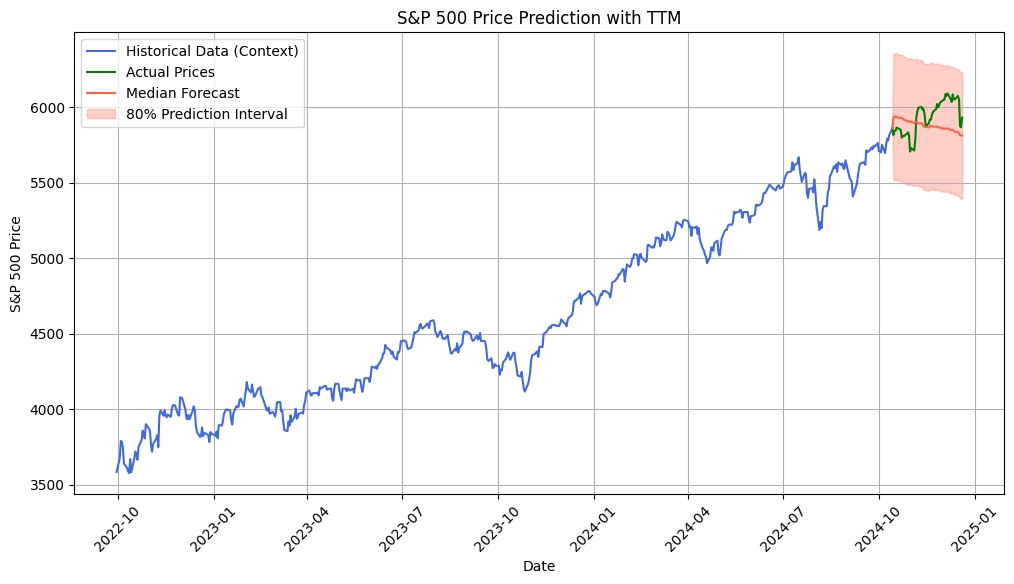


COVID Period Metrics:
MAE: 4512.7093
MSE: 20412716.9719
RMSE: 4518.0435
MAPE: 96.7925
SMAPE: 188.1194
MASE: 131.9427


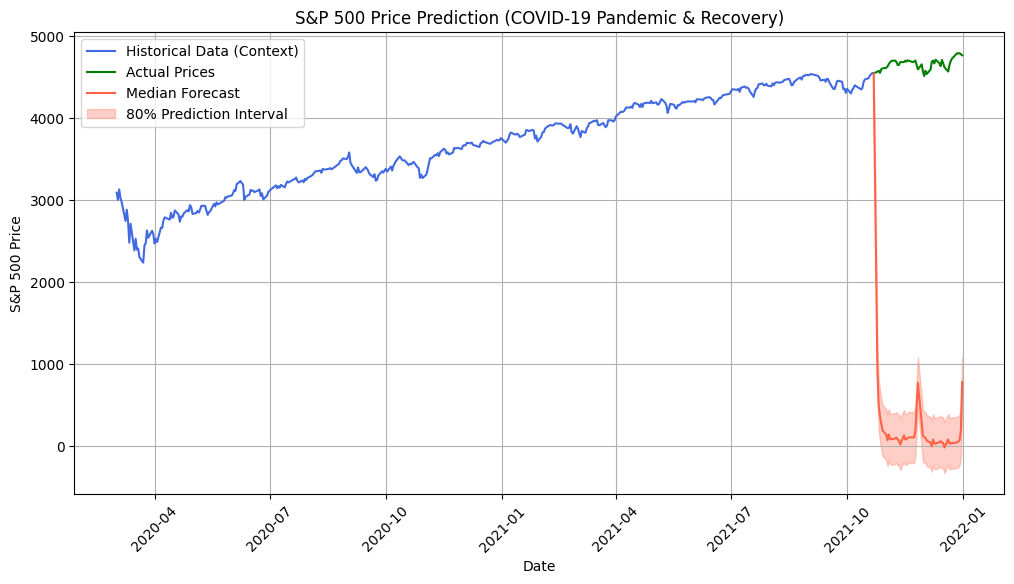

In [28]:
import numpy as np
import torch
from tsfm_public.toolkit.get_model import get_model

from data.snp500 import snp500_daily
from utils.metrics import calculate_metrics
from utils.visualization import plot_forecast

CONTEXT_WINDOW = 512
PREDICTION_WINDOW = 48

# Initialize TTM model
model = get_model(
    model_path="ibm-granite/granite-timeseries-ttm-r2",
    context_length=CONTEXT_WINDOW,
    prediction_length=PREDICTION_WINDOW
)

# Prepare the data - using raw Close prices
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]


def generate_forecast(context_data):
    """Generate and process forecast using TTM"""
    context = np.asarray(context_data).flatten()

    # If there's more context than needed, slice to the last CONTEXT_WINDOW elements.
    if len(context) > CONTEXT_WINDOW:
        context = context[-CONTEXT_WINDOW:]

    # If there's less context than needed, pad to the left.
    if len(context) < CONTEXT_WINDOW:
        padding = CONTEXT_WINDOW - len(context)
        context = np.pad(context, (padding, 0), mode='constant', constant_values=0)

    mean = np.mean(context)
    std = np.std(context)
    context_normalized = (context - mean) / std

    # (batch=1, sequence_length=512, channels=1)
    context_tensor = torch.tensor(context_normalized).float().unsqueeze(0).unsqueeze(-1)
    # If your TTM model expects 7 channels, replicate across that dimension
    context_tensor = context_tensor.repeat(1, 1, 7)

    with torch.no_grad():
        outputs = model(past_values=context_tensor)

    # outputs.prediction_outputs: shape => (batch_size=1, prediction_length, channels=7)
    predictions = outputs.prediction_outputs.squeeze().numpy()[:, 0]
    predictions = predictions * std + mean

    forecast_std = np.std(context) * 0.5
    median = predictions
    low = median - 1.28 * forecast_std
    high = median + 1.28 * forecast_std

    return low, median, high

# Generate full period forecast
context = sp500_d["Close"].values[-CONTEXT_WINDOW:]
if len(context) < CONTEXT_WINDOW:
    context = np.pad(context, (CONTEXT_WINDOW - len(context), 0), mode='constant', constant_values=0)

low, median, high = generate_forecast(context)

# Calculate and print metrics for full period
actual_prices = sp500_d["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_d["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_d,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with TTM",
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_d[
    (sp500_d["Date"] >= covid_start_date) & (sp500_d["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)
if len(covid_context) < CONTEXT_WINDOW:
    covid_context = np.pad(covid_context, (CONTEXT_WINDOW - len(covid_context), 0), mode='constant', constant_values=0)

low_covid, median_covid, high_covid = generate_forecast(covid_context)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)

# context: 512, prediction: 64

INFO:p-95468:t-8002182208:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-95468:t-8002182208:get_model.py:get_model:Selected prediction_length = 96
                    Hence, TTM will forecast using the `prediction_filter_length` argument to provide the requested prediction length.
                    Supported context lengths (CL) and forecast/prediction lengths (FL) for Model Card: ibm-granite/granite-timeseries-ttm-r2 are
                    {'CL': [512, 1024, 1536], 'FL': [96, 192, 336, 720]}
/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO:p-95468:t-8002182208:get_model.py:get_model:Model loaded successfully!
INFO:p-95468:t-8002182208:get_model.py:get_model:[TTM] context_len = 512, forecast_len = 96



Full Period Metrics:
MAE: 146.1244
MSE: 27417.8847
RMSE: 165.5835
MAPE: 2.4744
SMAPE: 2.4847
MASE: 4.5241


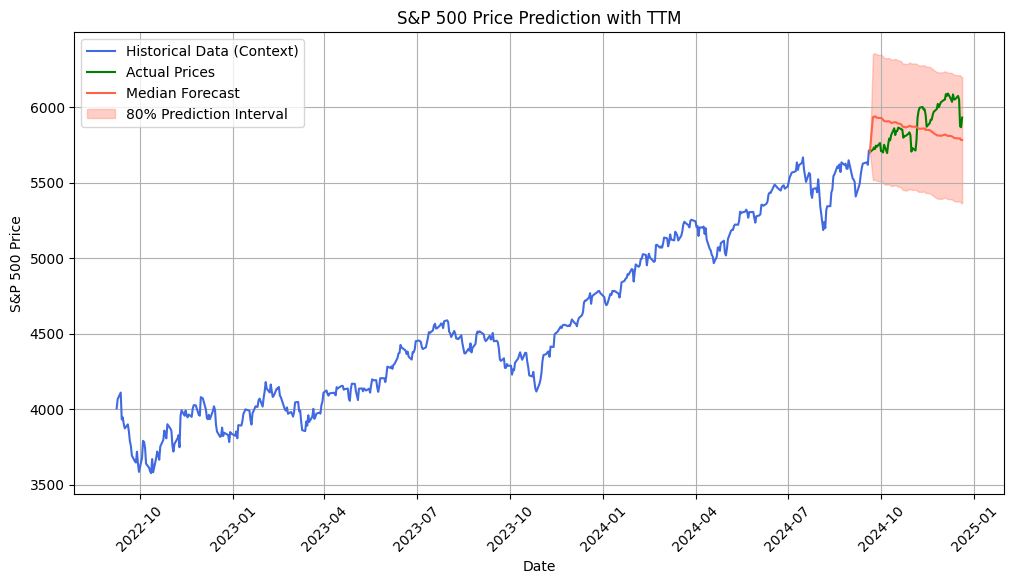


COVID Period Metrics:
MAE: 4453.1504
MSE: 19894856.3839
RMSE: 4460.3651
MAPE: 96.7025
SMAPE: 187.6639
MASE: 129.3623


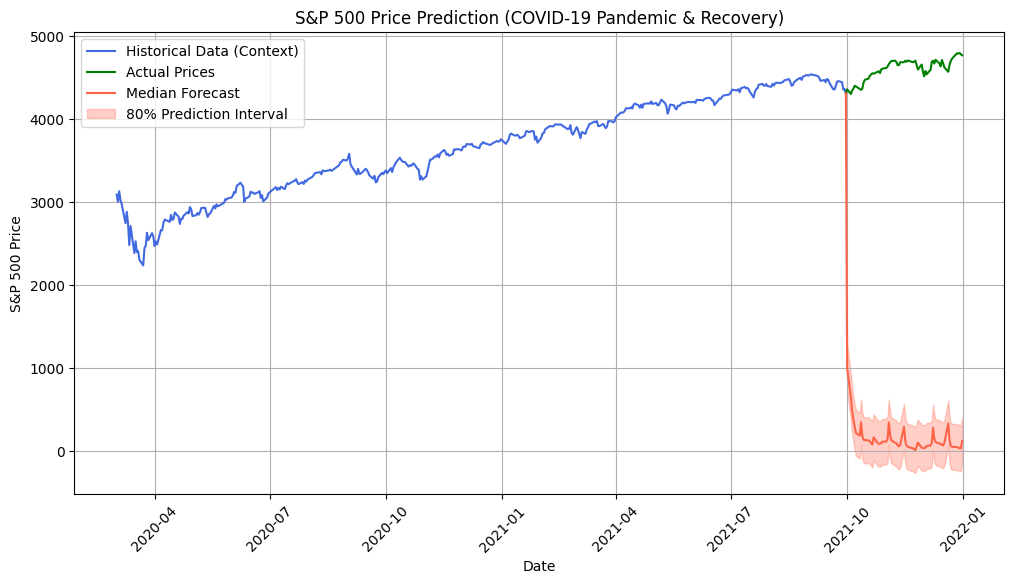

In [29]:
import numpy as np
import torch
from tsfm_public.toolkit.get_model import get_model

from data.snp500 import snp500_daily
from utils.metrics import calculate_metrics
from utils.visualization import plot_forecast

CONTEXT_WINDOW = 512
PREDICTION_WINDOW = 64

# Initialize TTM model
model = get_model(
    model_path="ibm-granite/granite-timeseries-ttm-r2",
    context_length=CONTEXT_WINDOW,
    prediction_length=PREDICTION_WINDOW
)

# Prepare the data - using raw Close prices
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]


def generate_forecast(context_data):
    """Generate and process forecast using TTM"""
    context = np.asarray(context_data).flatten()

    # If there's more context than needed, slice to the last CONTEXT_WINDOW elements.
    if len(context) > CONTEXT_WINDOW:
        context = context[-CONTEXT_WINDOW:]

    # If there's less context than needed, pad to the left.
    if len(context) < CONTEXT_WINDOW:
        padding = CONTEXT_WINDOW - len(context)
        context = np.pad(context, (padding, 0), mode='constant', constant_values=0)

    mean = np.mean(context)
    std = np.std(context)
    context_normalized = (context - mean) / std

    # (batch=1, sequence_length=512, channels=1)
    context_tensor = torch.tensor(context_normalized).float().unsqueeze(0).unsqueeze(-1)
    # If your TTM model expects 7 channels, replicate across that dimension
    context_tensor = context_tensor.repeat(1, 1, 7)

    with torch.no_grad():
        outputs = model(past_values=context_tensor)

    # outputs.prediction_outputs: shape => (batch_size=1, prediction_length, channels=7)
    predictions = outputs.prediction_outputs.squeeze().numpy()[:, 0]
    predictions = predictions * std + mean

    forecast_std = np.std(context) * 0.5
    median = predictions
    low = median - 1.28 * forecast_std
    high = median + 1.28 * forecast_std

    return low, median, high

# Generate full period forecast
context = sp500_d["Close"].values[-CONTEXT_WINDOW:]
if len(context) < CONTEXT_WINDOW:
    context = np.pad(context, (CONTEXT_WINDOW - len(context), 0), mode='constant', constant_values=0)

low, median, high = generate_forecast(context)

# Calculate and print metrics for full period
actual_prices = sp500_d["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_d["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_d,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with TTM",
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_d[
    (sp500_d["Date"] >= covid_start_date) & (sp500_d["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)
if len(covid_context) < CONTEXT_WINDOW:
    covid_context = np.pad(covid_context, (CONTEXT_WINDOW - len(covid_context), 0), mode='constant', constant_values=0)

low_covid, median_covid, high_covid = generate_forecast(covid_context)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)

# context: 512, prediction: 96

INFO:p-95468:t-8002182208:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-95468:t-8002182208:get_model.py:get_model:Selected prediction_length = 96
/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO:p-95468:t-8002182208:get_model.py:get_model:Model loaded successfully!
INFO:p-95468:t-8002182208:get_model.py:get_model:[TTM] context_len = 512, forecast_len = 96



Full Period Metrics:
MAE: 222.9343
MSE: 72316.5692
RMSE: 268.9174
MAPE: 3.9117
SMAPE: 3.8612
MASE: 6.9214


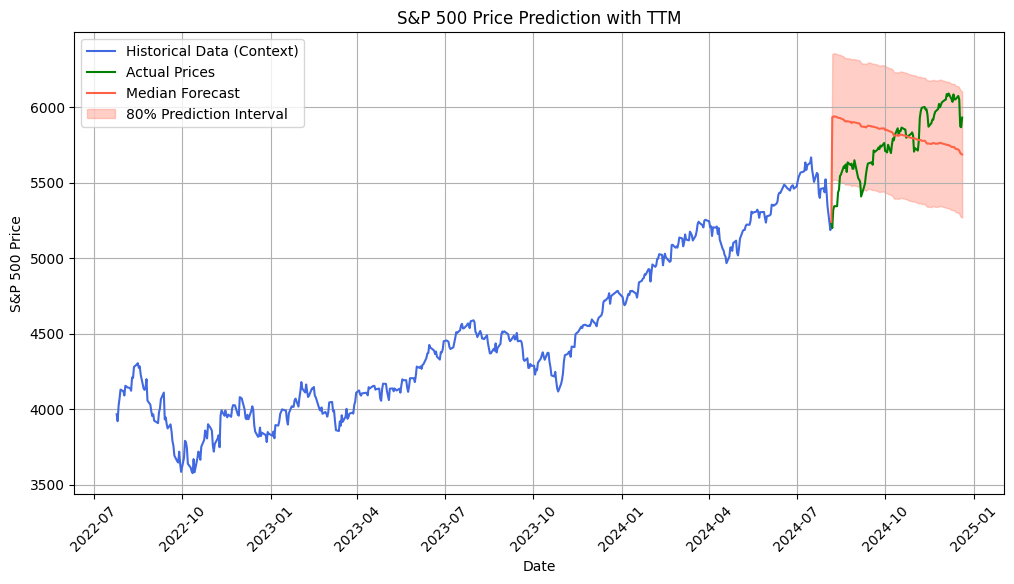


COVID Period Metrics:
MAE: 4436.8529
MSE: 19743320.2724
RMSE: 4443.3456
MAPE: 97.4181
SMAPE: 190.4096
MASE: 126.1056


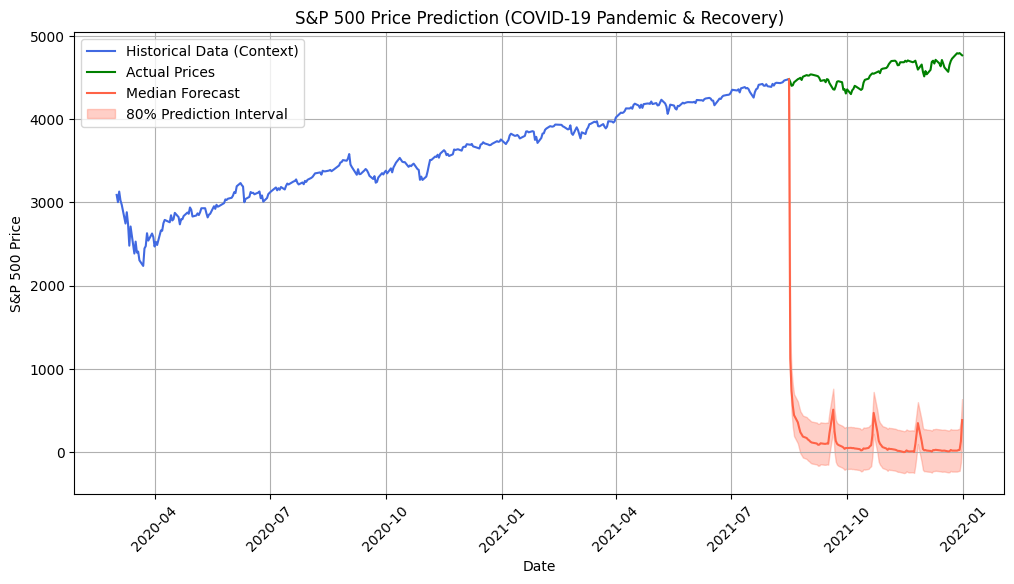

In [30]:
import numpy as np
import torch
from tsfm_public.toolkit.get_model import get_model

from data.snp500 import snp500_daily
from utils.metrics import calculate_metrics
from utils.visualization import plot_forecast

CONTEXT_WINDOW = 512
PREDICTION_WINDOW = 96

# Initialize TTM model
model = get_model(
    model_path="ibm-granite/granite-timeseries-ttm-r2",
    context_length=CONTEXT_WINDOW,
    prediction_length=PREDICTION_WINDOW
)

# Prepare the data - using raw Close prices
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]


def generate_forecast(context_data):
    """Generate and process forecast using TTM"""
    context = np.asarray(context_data).flatten()

    # If there's more context than needed, slice to the last CONTEXT_WINDOW elements.
    if len(context) > CONTEXT_WINDOW:
        context = context[-CONTEXT_WINDOW:]

    # If there's less context than needed, pad to the left.
    if len(context) < CONTEXT_WINDOW:
        padding = CONTEXT_WINDOW - len(context)
        context = np.pad(context, (padding, 0), mode='constant', constant_values=0)

    mean = np.mean(context)
    std = np.std(context)
    context_normalized = (context - mean) / std

    # (batch=1, sequence_length=512, channels=1)
    context_tensor = torch.tensor(context_normalized).float().unsqueeze(0).unsqueeze(-1)
    # If your TTM model expects 7 channels, replicate across that dimension
    context_tensor = context_tensor.repeat(1, 1, 7)

    with torch.no_grad():
        outputs = model(past_values=context_tensor)

    # outputs.prediction_outputs: shape => (batch_size=1, prediction_length, channels=7)
    predictions = outputs.prediction_outputs.squeeze().numpy()[:, 0]
    predictions = predictions * std + mean

    forecast_std = np.std(context) * 0.5
    median = predictions
    low = median - 1.28 * forecast_std
    high = median + 1.28 * forecast_std

    return low, median, high

# Generate full period forecast
context = sp500_d["Close"].values[-CONTEXT_WINDOW:]
if len(context) < CONTEXT_WINDOW:
    context = np.pad(context, (CONTEXT_WINDOW - len(context), 0), mode='constant', constant_values=0)

low, median, high = generate_forecast(context)

# Calculate and print metrics for full period
actual_prices = sp500_d["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_d["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_d,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with TTM",
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_d[
    (sp500_d["Date"] >= covid_start_date) & (sp500_d["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)
if len(covid_context) < CONTEXT_WINDOW:
    covid_context = np.pad(covid_context, (CONTEXT_WINDOW - len(covid_context), 0), mode='constant', constant_values=0)

low_covid, median_covid, high_covid = generate_forecast(covid_context)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)

# context: 512, prediction: 192

INFO:p-95468:t-8002182208:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-95468:t-8002182208:get_model.py:get_model:Selected prediction_length = 192
/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.63M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

INFO:p-95468:t-8002182208:get_model.py:get_model:Model loaded successfully!
INFO:p-95468:t-8002182208:get_model.py:get_model:[TTM] context_len = 512, forecast_len = 192



Full Period Metrics:
MAE: 397.6675
MSE: 222591.2895
RMSE: 471.7958
MAPE: 7.3804
SMAPE: 7.0733
MASE: 11.0410


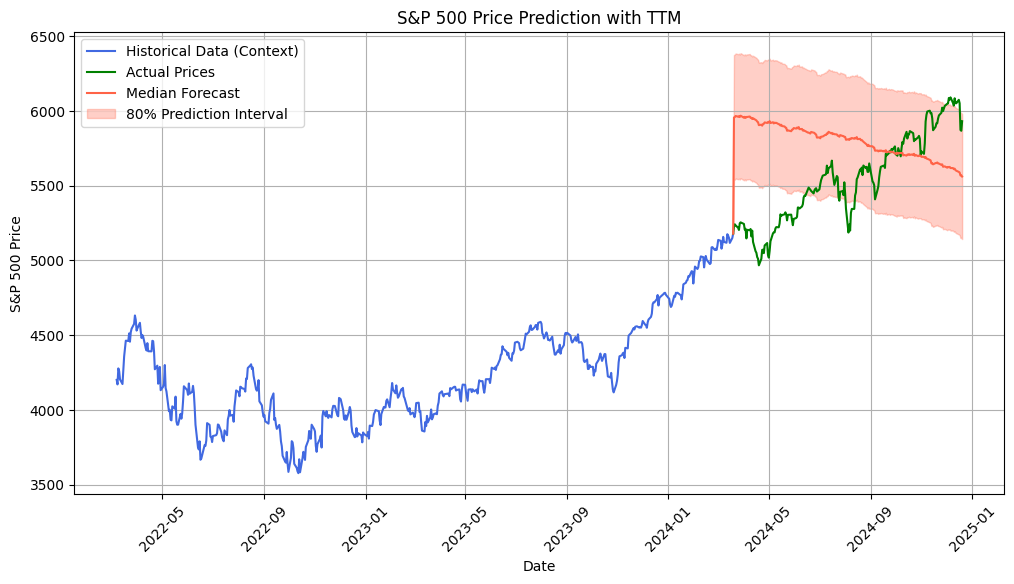


COVID Period Metrics:
MAE: 4339.6496
MSE: 18900403.6490
RMSE: 4347.4594
MAPE: 98.5423
SMAPE: 194.4293
MASE: 108.8411


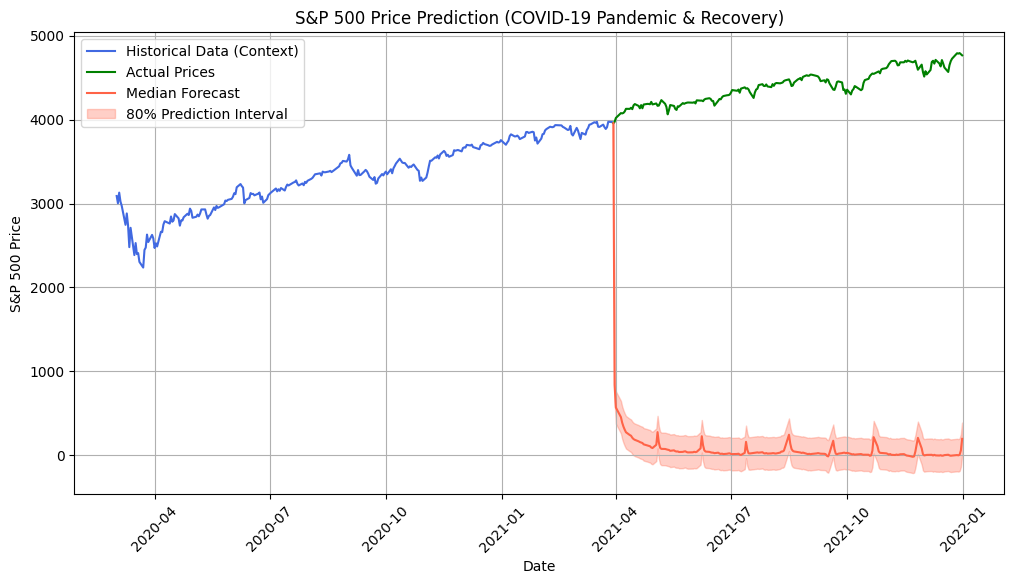

In [31]:
import numpy as np
import torch
from tsfm_public.toolkit.get_model import get_model

from data.snp500 import snp500_daily
from utils.metrics import calculate_metrics
from utils.visualization import plot_forecast

CONTEXT_WINDOW = 512
PREDICTION_WINDOW = 192

# Initialize TTM model
model = get_model(
    model_path="ibm-granite/granite-timeseries-ttm-r2",
    context_length=CONTEXT_WINDOW,
    prediction_length=PREDICTION_WINDOW
)

# Prepare the data - using raw Close prices
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]


def generate_forecast(context_data):
    """Generate and process forecast using TTM"""
    context = np.asarray(context_data).flatten()

    # If there's more context than needed, slice to the last CONTEXT_WINDOW elements.
    if len(context) > CONTEXT_WINDOW:
        context = context[-CONTEXT_WINDOW:]

    # If there's less context than needed, pad to the left.
    if len(context) < CONTEXT_WINDOW:
        padding = CONTEXT_WINDOW - len(context)
        context = np.pad(context, (padding, 0), mode='constant', constant_values=0)

    mean = np.mean(context)
    std = np.std(context)
    context_normalized = (context - mean) / std

    # (batch=1, sequence_length=512, channels=1)
    context_tensor = torch.tensor(context_normalized).float().unsqueeze(0).unsqueeze(-1)
    # If your TTM model expects 7 channels, replicate across that dimension
    context_tensor = context_tensor.repeat(1, 1, 7)

    with torch.no_grad():
        outputs = model(past_values=context_tensor)

    # outputs.prediction_outputs: shape => (batch_size=1, prediction_length, channels=7)
    predictions = outputs.prediction_outputs.squeeze().numpy()[:, 0]
    predictions = predictions * std + mean

    forecast_std = np.std(context) * 0.5
    median = predictions
    low = median - 1.28 * forecast_std
    high = median + 1.28 * forecast_std

    return low, median, high

# Generate full period forecast
context = sp500_d["Close"].values[-CONTEXT_WINDOW:]
if len(context) < CONTEXT_WINDOW:
    context = np.pad(context, (CONTEXT_WINDOW - len(context), 0), mode='constant', constant_values=0)

low, median, high = generate_forecast(context)

# Calculate and print metrics for full period
actual_prices = sp500_d["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_d["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_d,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with TTM",
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_d[
    (sp500_d["Date"] >= covid_start_date) & (sp500_d["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)
if len(covid_context) < CONTEXT_WINDOW:
    covid_context = np.pad(covid_context, (CONTEXT_WINDOW - len(covid_context), 0), mode='constant', constant_values=0)

low_covid, median_covid, high_covid = generate_forecast(covid_context)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)